In [28]:
import config
import time

import pandas as pd

from neo4j import GraphDatabase
import matplotlib.pyplot as plt

In [29]:
# set up connection
driver = GraphDatabase.driver(config.uri, auth=(config.user, config.password), encrypted=False)

# Check if connection did work
def check_connectivity(driver):
    try:
        with driver.session() as session:
            result = session.run("RETURN 1 as result")
            record = result.single()
            if record and record["result"] == 1:
                return True
            else:
                print('False')
                return False
    except Exception as e:
        return False


if check_connectivity(driver):
    print("Verbindung erfolgreich hergestellt.")
else:
    print("Fehler bei der Verbindungsherstellung.")

Verbindung erfolgreich hergestellt.


# Graph Database Algorithm

## Projection

In [30]:
def drop_projection() -> None:
    """
    Drop the projection of the graph.
    """
    with driver.session() as session:
        drop_projection_query = "CALL gds.graph.drop('gene_protein_graph')"
        
        session.run(drop_projection_query)
        print("Projection dropped.")

def create_projection() -> None:
    """
    Create a projection of the graph for the gene and protein nodes.
    """
    with driver.session() as session:
        projection_query = """
        CALL gds.graph.project(
            'gene_protein_graph',
            {
                gene: {
                    label: 'gene'
                },
                protein: {
                    label: 'protein'
                }
            },
            {
                INTERACTS: {
                    type: 'INTERACTS',
                    orientation: 'UNDIRECTED'
                },
                CONNECTION: {
                    type: 'CONNECTION',
                    orientation: 'UNDIRECTED'
                }
            }
        )
        """
        
        session.run(projection_query)
        print("Graph projection created.")

# drop_projection()
create_projection()

Graph projection created.


## Helper Functions

In [37]:
def drop_protein_nodes(df) -> pd.DataFrame:
    """
    Drop the protein nodes from the dataframe.
    :param df: The dataframe with the protein nodes.
    """
    return df[~df["node"].str.contains("ENSP")]
    
    

## Pagerank

In [38]:
def run_pagerank() -> pd.DataFrame:
    """
    Pagerank algorithm performed on the genes.
    :return: 
    """
    with driver.session() as session:
        query = """
        CALL gds.pageRank.stream('gene_protein_graph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name ,
               score, 
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY score DESC
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results

start = time.time()

df_pagerank = run_pagerank()

end = time.time()
print(f"Time taken: {round(end - start, 0)} seconds.")

Time taken: 5.0 seconds.


In [39]:
print("Only genes nodes:")
df_pagerank

Only genes nodes:


,node,gene_name,score,delta_tpm,delta_tpm_relevant
0,ENSG00000109339,MAPK10,67.208894,-0.051677,False
1,ENSG00000115392,FANCL,40.200986,0.149585,False
2,ENSG00000107862,GBF1,37.993365,0.034794,False
3,ENSG00000145362,ANK2,36.668287,-0.025229,False
4,ENSG00000121940,CLCC1,34.903938,0.028258,False
...,...,...,...,...,...
119352,ENSG00000188375,H3-5,0.151229,-0.080662,False
119353,ENSG00000183598,H3C13,0.151229,0.044729,False
119354,ENSG00000158417,EIF5B,0.151219,0.018658,False
119355,ENSG00000165704,HPRT1,0.151219,0.154396,False


In [40]:
print("Only genes with cancer active nodes:")
df_pagerank_relevant = df_pagerank.where(df_pagerank["delta_tpm_relevant"] == True).dropna()

df_pagerank_relevant.head(30)

Only genes with cancer active nodes:


,node,gene_name,score,delta_tpm,delta_tpm_relevant
23,ENSG00000165795,NDRG2,25.635548,-0.317776,True
58,ENSG00000161249,DMKN,19.901639,-0.203997,True
76,ENSG00000092529,CAPN3,18.136623,-0.310797,True
158,ENSG00000157103,SLC6A1,14.170587,-0.267816,True
173,ENSG00000110436,SLC1A2,13.729918,-0.233129,True
191,ENSG00000012048,BRCA1,13.289279,0.214719,True
199,ENSG00000022267,FHL1,12.850252,-0.217644,True
209,ENSG00000197971,MBP,12.849278,-0.296146,True
288,ENSG00000049540,ELN,11.119214,-0.246766,True
296,ENSG00000172995,ARPP21,11.090370,-0.201848,True


Text(0.5, 1.0, 'Histogram of Pagerank Scores')

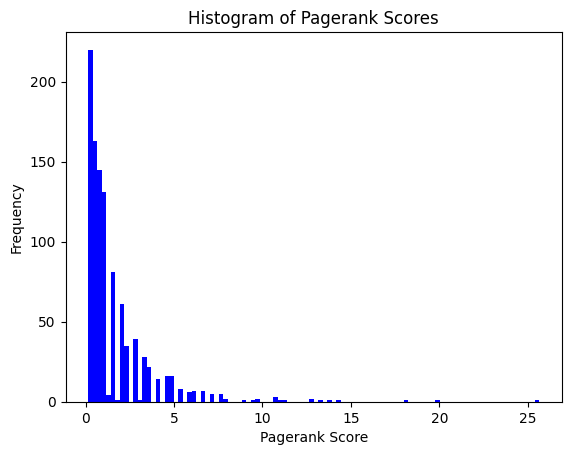

In [41]:
plt.hist(df_pagerank_relevant["score"], bins=100, color='blue')
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores")

## Clustering / Community Detection
### Louvain algorithm

In [42]:
def run_louvain() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.louvain.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY communityId
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
df_louvain = run_louvain()

In [43]:
df_louvain

,node,gene_name,communityId,delta_tpm,delta_tpm_relevant
18,ENSG00000138380,CARF,15923,-0.008726,False
34,ENSG00000110200,ANAPC15,15984,0.092733,False
38,ENSG00000163632,C3orf49,16022,0.022181,False
49,ENSG00000157764,BRAF,16070,0.038695,False
52,ENSG00000257008,GPR142,16140,0.031130,False
...,...,...,...,...,...
119311,ENSG00000130182,ZSCAN10,119319,0.009084,False
119328,ENSG00000235109,ZSCAN31,119331,0.090887,False
119341,ENSG00000214941,ZSWIM7,119343,0.007989,False
119352,ENSG00000214655,ZSWIM8,119344,-0.049506,False


In [46]:
# number of communities
print(f'Number of communities in general: \t\t\t\t{df_louvain["communityId"].nunique()}')

# group by communityId and count the number of cancer active nodes and the total number of nodes
df_louvain_agg = df_louvain.groupby("communityId").agg({"delta_tpm_relevant": "sum", "node": "count"})

# drop communities with a single node
df_louvain_agg = df_louvain_agg.where(df_louvain_agg["node"] > 1).dropna()

print(f'Number of communities with more then a single node: \t{df_louvain_agg.shape[0]}')

Number of communities in general: 				9796
Number of communities: 	9


In [47]:
# calculate the ratio of cancer active nodes to the total number of nodes
df_louvain_agg["ratio"] = df_louvain_agg["delta_tpm_relevant"] / df_louvain_agg["node"]

print("Communities with delta tpm relevant nodes:")
df_louvain_agg

Communities with delta tpm relevant nodes:


,delta_tpm_relevant,node,ratio
communityId,,,
25315,0,47.0,0.0
43180,54,1584.0,0.034091
62670,12,85.0,0.141176
72329,1,332.0,0.003012
96554,8,1204.0,0.006645
100799,218,1346.0,0.161961
102254,60,973.0,0.061665
103736,88,452.0,0.19469
105354,62,1816.0,0.034141


In [ ]:
# TODO And now?

### Leiden algorithm

In [48]:
def run_leiden() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.leiden.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY communityId
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
df_leiden = run_leiden()

In [49]:
df_leiden

,node,gene_name,communityId,delta_tpm,delta_tpm_relevant
1720,ENSG00000121410,A1BG,0,-0.164171,False
1721,ENSG00000144476,ACKR3,0,-0.077534,False
1722,ENSG00000129048,ACKR4,0,-0.064713,False
1723,ENSG00000114739,ACVR2B,0,0.070526,False
1724,ENSG00000138316,ADAMTS14,0,0.122470,False
...,...,...,...,...,...
119332,ENSG00000204271,SPIN3,9991,0.106216,False
119333,ENSG00000171791,BCL2,9993,0.080746,False
119341,ENSG00000163576,EFHB,9994,-0.021394,False
119345,ENSG00000146122,DAAM2,9995,-0.228771,True


In [51]:
# number of communities
print(f'Number of communities in general: \t\t\t\t{df_leiden["communityId"].nunique()}')

# group by communityId and count the number of cancer active nodes and the total number of nodes
df_leiden_agg = df_leiden.groupby("communityId").agg({"delta_tpm_relevant": "sum", "node": "count"})

df_leiden_agg

Number of communities in general: 				9727


,delta_tpm_relevant,node
communityId,,
0,218,1366
1,False,1
2,False,1
3,False,1
4,False,1
...,...,...
9991,False,1
9993,False,1
9994,False,1


In [53]:
# drop communities with a single node
df_leiden_agg = df_leiden_agg.where(df_leiden_agg["node"] > 1).dropna()

print(f'Number of communities with more then a single node: \t{df_leiden_agg.shape[0]}')

df_leiden_agg

Number of communities with more then a single node: 	7


,delta_tpm_relevant,node
communityId,,
0,218,1366.0
5,6,1203.0
7,17,689.0
11,68,1007.0
15,93,2358.0
22,89,1202.0
135,18,81.0


## Similarity
### KNN

In [ ]:
def run_knn() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.knn.stream('gene_protein_graph')
        YIELD nodeId, otherNodeId, weight
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               gds.util.asNode(otherNodeId).id AS other_node,
               gds.util.asNode(otherNodeId).gene_name AS other_gene_name,
               weight
        """
    
        result = session.run(query)
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
# df_knn = run_knn()